# Introduction

Overview of the dataset, context, etc...

In [91]:
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, StandardScaler

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings for notebook
import warnings
warnings.filterwarnings('ignore')

# 1 - Initial data processing and EDA

## 1.1 - Loading the data

In [92]:
# data_dir = os.path.join("/kaggle", "input", "store-sales-time-series-forecasting")
data_dir = os.path.join("store-sales-time-series-forecasting")

original_data = {}

for file_name in os.listdir(data_dir):
    original_data[file_name.replace(".csv", "")] = pd.read_csv(os.path.join(data_dir, file_name))

    if "date" in original_data[file_name.replace(".csv", "")].columns:
        original_data[file_name.replace(".csv", "")]["date"] = pd.to_datetime(original_data[file_name.replace(".csv", "")]["date"])
        original_data[file_name.replace(".csv", "")] = original_data[file_name.replace(".csv", "")].set_index("date")
    
    print(f"Head of the {file_name} table")
    print(original_data[file_name.replace(".csv", "")].head())
    print("\n\n")

Head of the holidays_events.csv table
               type    locale locale_name                    description  \
date                                                                       
2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

            transferred  
date                     
2012-03-02        False  
2012-04-01        False  
2012-04-12        False  
2012-04-14        False  
2012-04-21        False  



Head of the oil.csv table
            dcoilwtico
date                  
2013-01-01         NaN
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-07       93.20



Head of the sample_submission.csv table
        id  sa

## 1.2 - Sales table (containing the outcome)

Plot of total sales per store cluster. Although this plot doesn't give us a huge amount of detail for each time series we can make a few observations:
 - Some stores have 0 sales for long periods, probably indicating they are not yet open.
 - Some stores seam to have similar seasonal peaks/troughs, which likely correspond to holidays during which the stores are closed (we can probably use the `holiday.csv` dataset to handle this.)
 - Some stores have longer term trends, whereas others have a relatively stable means.
 - There may be more frequent seasonal trends that we can pick out upon closer inspection.

In [93]:
def make_lineplot(data, x, y, group=None, grid=False, sharey=True):
    """
    Make a lineplot, where date is the x-axis, the outcome of interest is on the y 
    and some grouping variable is plotted using a grid or colour
    """

    data_copy = data.copy()

    if group is not None:
        data_copy[group] = data_copy[group].astype(str)

    if grid:
        g = sns.FacetGrid(data=data_copy, col=group, col_wrap=3, aspect=1.5, sharey=sharey)
        g.map(sns.lineplot, x, y, linewidth=0.5)
        g.add_legend()
        plt.tight_layout()
        return g
    else:
        sns.lineplot(data=data_copy, x=x, y=y, hue=group)
        plt.grid(True)

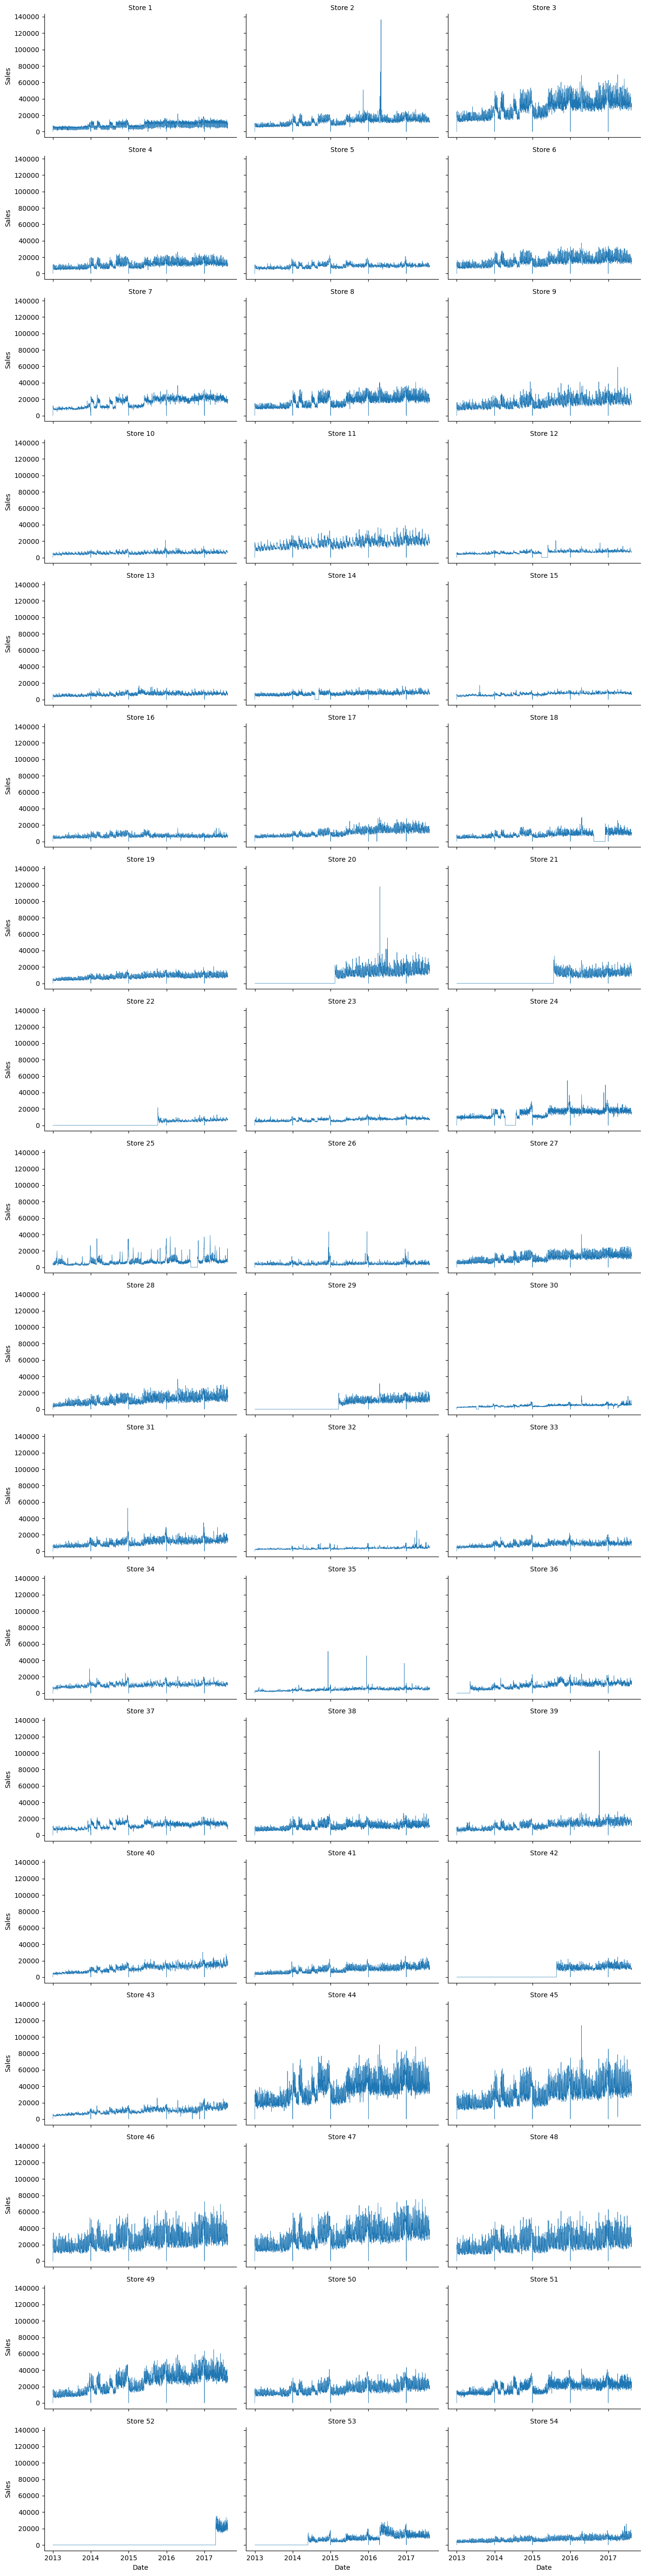

In [94]:
# Merge with store data
train_aggr_by_store = original_data["train"].join(original_data["stores"].set_index("store_nbr"), on="store_nbr")

# Aggregate by store
train_aggr_by_store = train_aggr_by_store.groupby(["date", "store_nbr"]).sales.sum().reset_index()

g = make_lineplot(data=train_aggr_by_store, x="date", y="sales", group="store_nbr", grid=True)
g.set_axis_labels('Date', 'Sales')
g.set_titles('Store {col_name}')
plt.show()

Plot of total sales per item category across stores - note that we allow for different y axis scales since different product categories have very different total sales.

Again, we see some broad patterns:
 - Some products only started being sold more recently than others.
 - Again, many products have regular yearly troughs likely around holidays. Some products also have consistent peaks, which might indicate that these are being bought before holidays (e.g, school products before the new school year, frozen foods before the end of year holidays.)
 - Some products had intermittent periods of 0 sales from 2013 to 2016. It's hard to ascertain why this is without further information, but it does seem like there are corresponding periods of higher sales for other products, like "beverages". Perhaps this is due to changes in product labelling as opposed to real changes in the trend. Ideally we would get to the bottom of this and fix the labelling, but that will be out of scope for this analysis of public data.
 - Some products had a sudden boost in sales in 2017. Perhaps this is a real change in sales or something else.
 - Some products have other strange patterns. Baby care products had a huge spike in sales in 2015. Books only started being sold in late 2016 by the looks of things, at which point they sold well but dropped off over time.

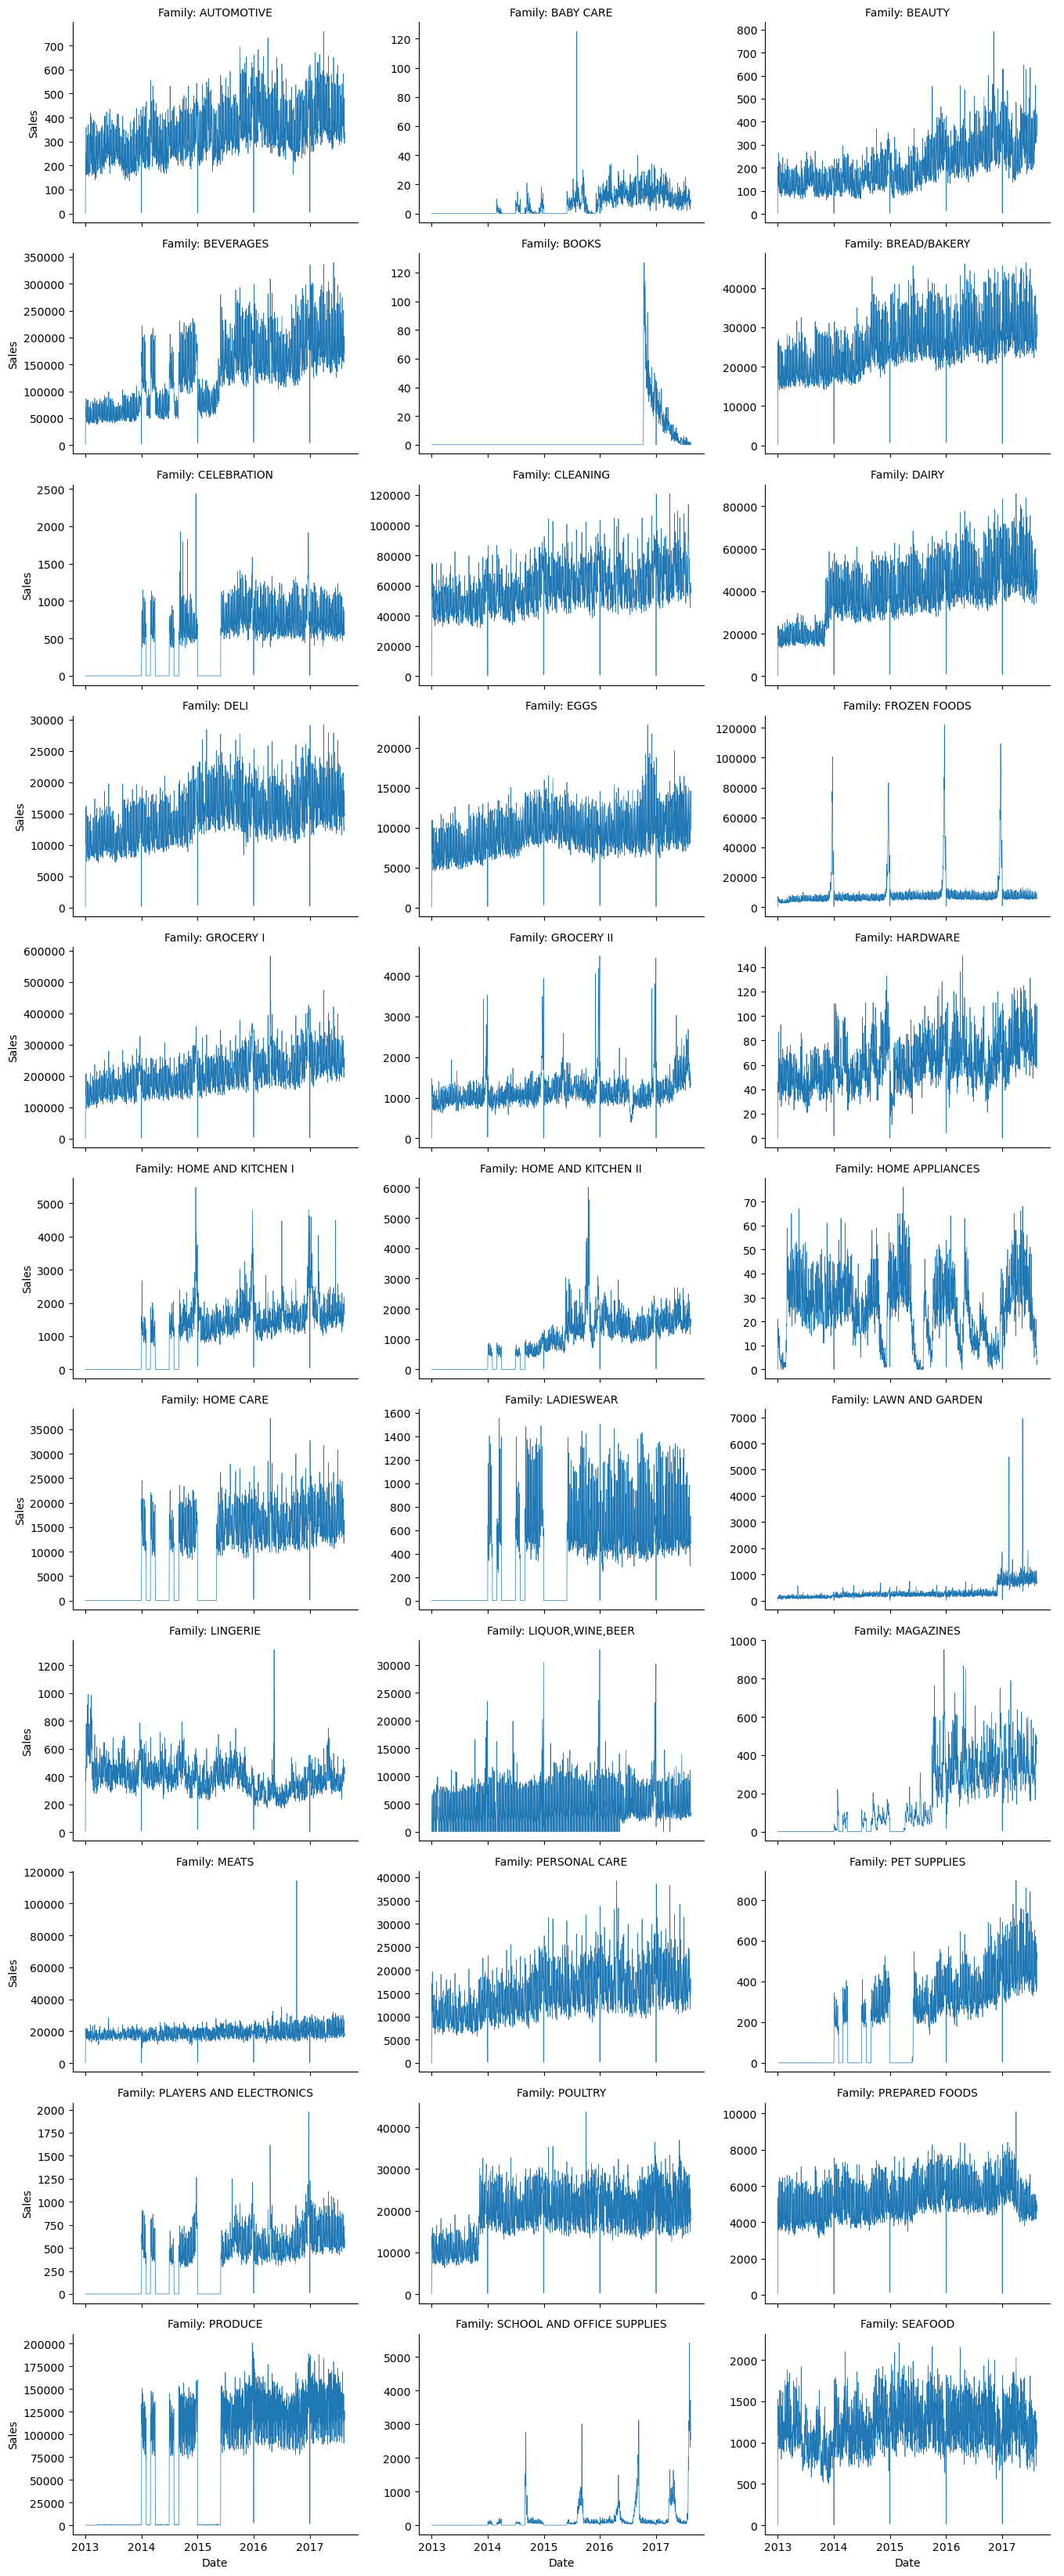

In [95]:
# Aggregate by item family
train_aggr_by_family = original_data["train"].groupby(["date", "family"]).sales.sum().reset_index()
train_aggr_by_family["family"] = train_aggr_by_family["family"].astype(str)

g = make_lineplot(train_aggr_by_family, x="date", y="sales", group="family", grid=True, sharey=False)
g.set_axis_labels('Date', 'Sales')
g.set_titles('Family: {col_name}')
plt.show()

No sales are recorded on Christmas day

In [96]:
train_date_range = pd.date_range("2013-01-01", "2017-08-15")
train_date_range[~train_date_range.isin(original_data["train"].index[original_data["train"]["store_nbr"] == 1])]

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

## 1.3 - Transaction table

In the transactions data we tend to see strong seasonal patterns for each store. There don't seem to be such strong trends compared to the sales / product-specific series. For the transactions data, the data are missing when the stores are closed, whereas in the sales data there is no missing data, it appears to have simply been set to 0. 

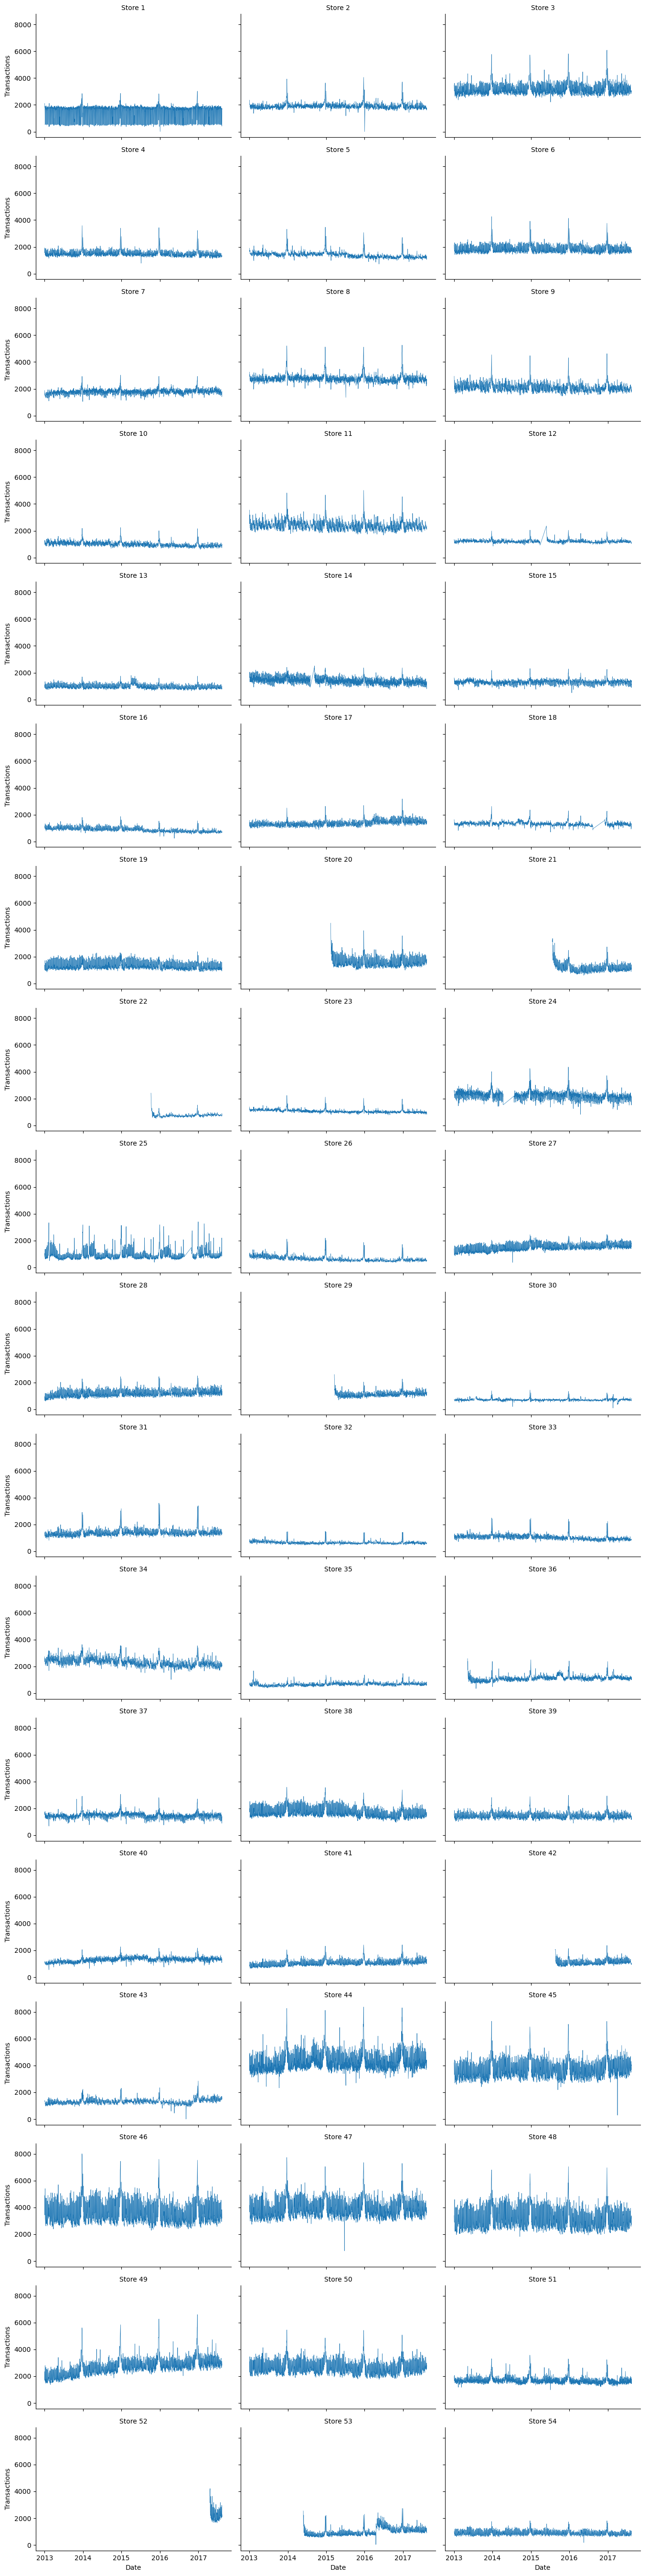

In [97]:
original_data["transactions"] = original_data["transactions"].sort_values("store_nbr")

g = make_lineplot(original_data["transactions"].reset_index(), x="date", y="transactions", group="store_nbr", grid=True)
g.set_axis_labels('Date', 'Transactions')
g.set_titles('Store {col_name}')
plt.show()

## 1.4 - Oil table

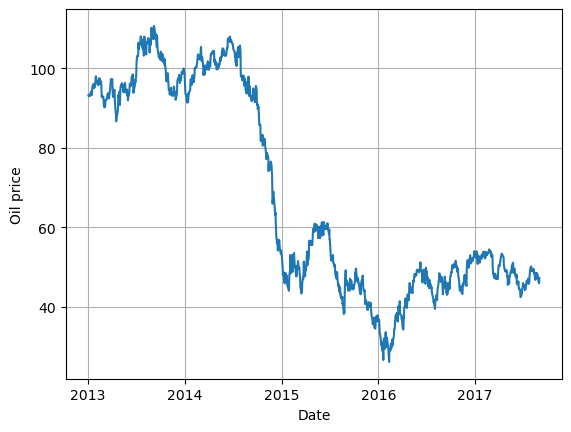

In [98]:
make_lineplot(original_data["oil"].reset_index(), x="date", y="dcoilwtico")
plt.xlabel("Date")
plt.ylabel("Oil price")
plt.show()

Plot of NA values for the oil column over time

<Axes: xlabel='date'>

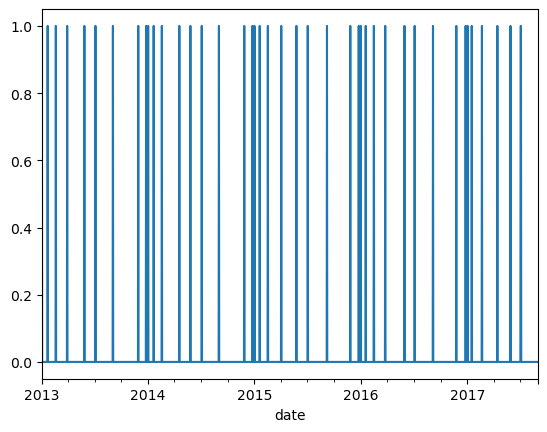

In [99]:
original_data["oil"]['dcoilwtico'].isna().resample('D').sum().plot()

There are some commonalities to the missing data - e.g., data are generally missing on the first day of the year, the 4th of July and Christmas day

In [100]:
missing_dates = original_data["oil"].index[original_data["oil"]['dcoilwtico'].isna()]
(missing_dates.month.astype(str) + "_" + missing_dates.day.astype(str)).value_counts()

date
1_1      4
7_4      4
12_25    3
7_3      2
1_21     1
3_29     1
5_27     1
9_2      1
11_28    1
2_18     1
2_17     1
4_18     1
5_26     1
9_1      1
11_27    1
1_19     1
2_16     1
1_20     1
4_3      1
5_25     1
9_7      1
11_26    1
1_18     1
2_15     1
3_25     1
5_30     1
9_5      1
11_24    1
12_26    1
1_2      1
1_16     1
2_20     1
4_14     1
5_29     1
Name: count, dtype: int64

## 1.5 - Holiday table

The data, shown below, indicate the holiday date, type and location. Ideally we would match up these locations with the store locations, but we don't have this data so we will have to make do.

In [101]:
original_data["holidays_events"]

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


The holiday data require some simplification to be useful. There are a few different holiday types:
 * Holiday - a holiday day
 * Event - some kind of event, like Black Friday
 * Additional - Days added to a regular calendar holiday
 * Transfer - The event is not usually celebrated on this day, but was moved to this date
 * Bridge - Extra days added to a holiday (e.g., to extend the break across a long weekend)
 * Work day - A day not normally scheduled for work (like a Saturday) that is intended to pay back the bridge

And there's a transferred column, indicating holidays that have been moved. They are of type "Holiday" but are, in fact, more like a regular working day.

In [102]:
original_data["holidays_events"]["type"].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

Below, we change the holiday types slightly to indicate transferred holidays. So, the "Transfer" type holiday is a holiday that is not usually celebrated on that day, whereas the new "Holiday - transferred" is usually celebrated as a holiday, but is actually more like a regular work day. This notation is a bit confusing, but we will simplify it shortly!

In [103]:
original_data["holidays_events"]["type"][original_data["holidays_events"]["transferred"]] = "Holiday - transferred"
original_data["holidays_events"]["type"].value_counts()

type
Holiday                  209
Event                     56
Additional                51
Transfer                  12
Holiday - transferred     12
Bridge                     5
Work Day                   5
Name: count, dtype: int64

Now let's see the total sales across all stores and product types, stratified by holiday type. This may hide the contributions of local holidays (e.g., a local holiday may affect one store greatly but not the sales aggregated across all stores), but hopefully it will give us an idea of the contribution of the different types.

Many of the holiday types have boosted sales (e.g., "Additional", "Bridge", "Event") compared to days without a holiday. The "Work day" and "Holiday - transferred" are days when people are working, and so have similar sales distributions to "No holiday". Surprisingly, the "Holiday" category is not too different from "No holiday". Perhaps this is because these are largely local events that are only relevant to a subset of stores. 

The locale distributions have boosted sales for national holidays, but regional and local holidays are more similar to no holiday days in terms of total sales.

Based on our understanding of these data we will merge the "Additional", "Bridge" and "Transfer" categories (non-normal days off), and we will merge the "Work day" and "Holiday - transferred" categories (non-normal days on).

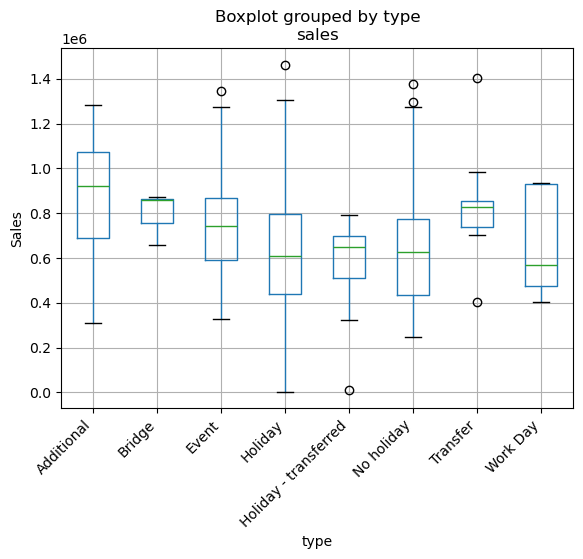

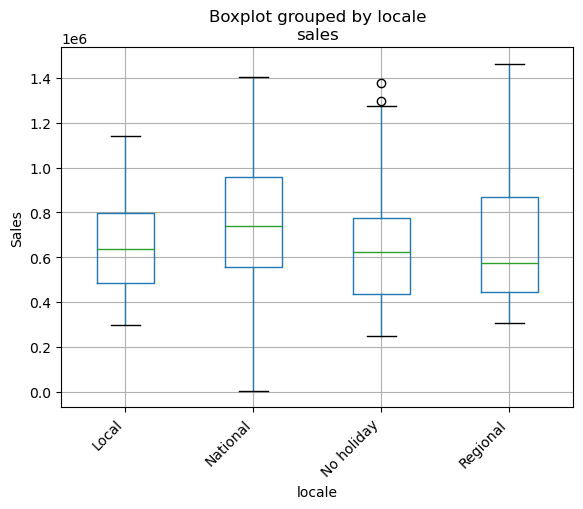

In [104]:
# Aggregate
train_aggr = original_data["train"].groupby(["date"]).sales.sum().reset_index()
train_aggr = train_aggr.set_index("date")

# Merge with holiday data
train_aggr = train_aggr.join(original_data["holidays_events"])
train_aggr["type"][train_aggr["type"].isna()] = "No holiday"
train_aggr["locale"][train_aggr["locale"].isna()] = "No holiday"

ax = train_aggr.boxplot("sales", "type")
plt.xticks(
    rotation=45,
    horizontalalignment='right'
)
plt.ylabel("Sales")
plt.show()

ax = train_aggr.boxplot("sales", "locale")
plt.xticks(
    rotation=45,
    horizontalalignment='right'
)
plt.ylabel("Sales")
plt.show()

Next we look at the descriptions. There are lots of unique values, but a lot seem to be quite similar (e.g., Fundacion, Cantonizacion and Provincializacion of different areas) (e.g., Navidad-4, Navidad+1). We already encode the location information separately in the locale_name. We will apply a naive approach to reduce these down by taking the first word of each description and using this as a category.

Descriptions before simplification:

In [105]:
original_data["holidays_events"]["description"].value_counts()

description
Carnaval                           10
Fundacion de Ibarra                 7
Fundacion de Cuenca                 7
Cantonizacion de Libertad           6
Cantonizacion de Riobamba           6
                                   ..
Traslado Fundacion de Guayaquil     1
Puente Dia de Difuntos              1
Recupero Puente Dia de Difuntos     1
Traslado Primer dia del ano         1
Traslado Fundacion de Quito         1
Name: count, Length: 103, dtype: int64

Descriptions after simplification:

In [106]:
# Simplify
original_data["holidays_events"]["description_short"] = original_data["holidays_events"]["description"].str.split().str[0]
original_data["holidays_events"]["description_short"] = original_data["holidays_events"]["description_short"].str.split("-").str[0]
original_data["holidays_events"]["description_short"] = original_data["holidays_events"]["description_short"].str.split("+").str[0]

# Merge Cyber and Black
original_data["holidays_events"]["description_short"][original_data["holidays_events"]["description_short"] == "Cyber"] = "Black"

# Show new description counts
original_data["holidays_events"]["description_short"].value_counts()

description_short
Fundacion            78
Cantonizacion        54
Navidad              36
Terremoto            31
Independencia        30
Provincializacion    24
Dia                  21
Primer               16
Mundial              13
Carnaval             10
Traslado             10
Black                 6
Puente                5
Batalla               5
Viernes               5
Recupero              5
Inauguracion          1
Name: count, dtype: int64

The final dataset, prior to encoding, is as follows. We order the data so that the more major holidays come first. Shortly, we will handle cases where multiple holidays occur on the same date, and in some cases we will prefer to keep the major holidays and discard the less frequent/impactful ones.

In [107]:
# Order categories
original_data["holidays_events"]['locale'] = pd.Categorical(
    original_data["holidays_events"]['locale'], 
    ["National", "Regional", "Local"], 
    ordered=True
)
original_data["holidays_events"]['type'] = pd.Categorical(
    original_data["holidays_events"]['type'], 
    categories=original_data["holidays_events"]["type"].value_counts().index, 
    ordered=True
)
original_data["holidays_events"]['locale_name'] = pd.Categorical(
    original_data["holidays_events"]['locale_name'], 
    categories=original_data["holidays_events"]["locale_name"].value_counts().index, 
    ordered=True
)
original_data["holidays_events"]['description_short'] = pd.Categorical(
    original_data["holidays_events"]['description_short'], 
    categories=original_data["holidays_events"]["description_short"].value_counts().index, 
    ordered=True
)

original_data["holidays_events"] = original_data["holidays_events"].sort_values(["locale", "type", "description", "locale_name"])
original_data["holidays_events"]

,type,locale,locale_name,description,transferred,description_short
date,,,,,,
2013-05-24,Holiday,National,Ecuador,Batalla de Pichincha,False,Batalla
2014-05-24,Holiday,National,Ecuador,Batalla de Pichincha,False,Batalla
2015-05-24,Holiday,National,Ecuador,Batalla de Pichincha,False,Batalla
2013-02-11,Holiday,National,Ecuador,Carnaval,False,Carnaval
2013-02-12,Holiday,National,Ecuador,Carnaval,False,Carnaval
...,...,...,...,...,...,...
2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False,Traslado
2017-04-12,Holiday - transferred,Local,Cuenca,Fundacion de Cuenca,True,Fundacion
2016-07-25,Holiday - transferred,Local,Guayaquil,Fundacion de Guayaquil,True,Fundacion


Finally, we apply one-hot and value encoding to the holiday data. We do this to the entire dataset rather than "training" the encoders on the train data then applying to the test data under the assumption we know the upcoming holidays in advance. We're only predicting half a month into the future in the kaggle test set, so this seems like a reasonable expectation.

After applying one-hot encoding we deal with duplicates by taking the maximum of each variable, meaning we retain information about the duplicate holidays. For the value encoder this is more difficult to do, and we simply keep the more frequent holiday event where there are duplicates. For each, we fill the non-holiday days with 0s. 

In [108]:
cols_to_encode = ["type", "locale", "locale_name", "description_short"]
encoded_holidays = {}

# One hot encode
oh_enc = OneHotEncoder(sparse_output=False)

encoded_holidays["onehot"] = oh_enc.fit_transform(original_data["holidays_events"][cols_to_encode])
encoded_holidays["onehot"] = pd.DataFrame(encoded_holidays["onehot"], columns=oh_enc.get_feature_names_out(), index=original_data["holidays_events"].index)
assert not encoded_holidays["onehot"].columns.duplicated().any()  # No redundant columns

# Collapse duplicate rows, then fill rows for non-holiday dates with 0s
encoded_holidays["onehot"] = encoded_holidays["onehot"].groupby(encoded_holidays["onehot"].index).max()
encoded_holidays["onehot"] = encoded_holidays["onehot"].asfreq("d")

for col in encoded_holidays["onehot"].columns:
    encoded_holidays["onehot"][col][encoded_holidays["onehot"][col].isna()] = 0
    encoded_holidays["onehot"][col] = encoded_holidays["onehot"][col].astype(int)

# Label encode
label_encoders = {}
encoded_holidays["value"] = pd.DataFrame(index=original_data["holidays_events"].index)

for col in cols_to_encode:
    label_encoders[col] = LabelEncoder()
    encoded_holidays["value"][col + "_label"] = label_encoders[col].fit_transform(original_data["holidays_events"][col])
    encoded_holidays["value"][col + "_label"] += 1  # Don't use 0, we will use this for timepoints with no holidays
    
# Remove duplicate encodings for these labels and add rows for non-holiday dates (then fill them with 0s)
encoded_holidays["value"] = encoded_holidays["value"][~encoded_holidays["value"].index.duplicated(keep='first')]
encoded_holidays["value"] = encoded_holidays["value"].asfreq("d")

for col in cols_to_encode:
    encoded_holidays["value"][col + "_label"][encoded_holidays["value"][col + "_label"].isna()] = 0
    encoded_holidays["value"][col + "_label"] = encoded_holidays["value"][col + "_label"].astype(int)

encoded_holidays["onehot"].columns, encoded_holidays["value"].columns = "holiday_" + encoded_holidays["onehot"].columns, "holiday_" + encoded_holidays["value"].columns

One-hot encoded table

In [109]:
encoded_holidays["onehot"]

,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Holiday - transferred,holiday_type_Transfer,holiday_type_Work Day,holiday_locale_Local,holiday_locale_National,holiday_locale_Regional,...,holiday_description_short_Independencia,holiday_description_short_Mundial,holiday_description_short_Navidad,holiday_description_short_Primer,holiday_description_short_Provincializacion,holiday_description_short_Puente,holiday_description_short_Recupero,holiday_description_short_Terremoto,holiday_description_short_Traslado,holiday_description_short_Viernes
date,,,,,,,,,,,,,,,,,,,,,
2012-03-02,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-03-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-03-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-03-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-03-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,1,0,0,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
2017-12-23,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2017-12-24,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


Value encoded table

In [110]:
encoded_holidays["value"]

,holiday_type_label,holiday_locale_label,holiday_locale_name_label,holiday_description_short_label
date,,,,
2012-03-02,4,1,16,6
2012-03-03,0,0,0,0
2012-03-04,0,0,0,0
2012-03-05,0,0,0,0
2012-03-06,0,0,0,0
...,...,...,...,...
2017-12-22,1,2,5,10
2017-12-23,1,2,5,10
2017-12-24,1,2,5,10


## 1.6 - Joining datasets and encoding variables

We combine the train and test datasets, while being careful not to introduce data leakage. Most transformations (e.g., scaling) will be done alongside the model training and validation process.

The main dataset is joined with the auxiliary datasets, including the "stores", "oil" and "transactions" tables.

We avoid joining with the holiday data at this point and instead join the holiday data after encoding the variables as this is more convenient.

Here, we also label datapoints with NA transactions and 0 sales, which usually indicate that the stores were not open at this point. 10% of the data points have NA transactions. 0.1% have no recorded transactions and positive sales numbers, so this approach is not perfect at identifying store closures but is likely close. Ideally, we would investigate why there would be NA transaction data points for stores that have positive sales, but this is not viable for us.

In [111]:
# Combine datasets
original_data["train"]["split"], original_data["test"]["split"] = "train", "kaggle_test"
full_dataset = pd.concat([original_data["train"], original_data["test"]])

# TODO: Define validation split

# Join the store and oil data
full_dataset = full_dataset.join(original_data["stores"].set_index("store_nbr"), on="store_nbr", how="left")
full_dataset = full_dataset.join(original_data["oil"], how="left")

# Join the transactions data - here we label datapoints where the stores appear to be closed
full_dataset = full_dataset.join(original_data["transactions"].reset_index().set_index(["date", "store_nbr"]), on=["date", "store_nbr"], how="left")
full_dataset["store_closed"] = ((full_dataset["sales"] == 0) & full_dataset["transactions"].isna()).astype(int)

full_dataset

,id,store_nbr,family,sales,onpromotion,split,city,state,type,cluster,dcoilwtico,transactions,store_closed
date,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,train,Quito,Pichincha,D,13,NaN,NaN,1
2013-01-01,1,1,BABY CARE,0.0,0,train,Quito,Pichincha,D,13,NaN,NaN,1
2013-01-01,2,1,BEAUTY,0.0,0,train,Quito,Pichincha,D,13,NaN,NaN,1
2013-01-01,3,1,BEVERAGES,0.0,0,train,Quito,Pichincha,D,13,NaN,NaN,1
2013-01-01,4,1,BOOKS,0.0,0,train,Quito,Pichincha,D,13,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,NaN,1,kaggle_test,Quito,Pichincha,B,6,47.26,NaN,0
2017-08-31,3029396,9,PREPARED FOODS,NaN,0,kaggle_test,Quito,Pichincha,B,6,47.26,NaN,0
2017-08-31,3029397,9,PRODUCE,NaN,1,kaggle_test,Quito,Pichincha,B,6,47.26,NaN,0


Now we'll create a function, `get_encoded_dataset`, that will take these data and apply the transformations we want, such as label encoding, one-hot encoding and scaling. The code is relatively complex because we set the function up to allow the application of multiple different types of transformation based on a dictionary of transformations. This will make it easy to apply different types of transformations for different models later on. 

We perform encoding/transformation sets separately on the main dataset and holidays, then join them. The motivation behind transforming the holiday data separately was that there were cases of multiple holidays for a given date that were more convenient to deal with separetely post-transformation (see previous section). 

Note that we're not adding any sort of time-series-specific transformation here like lags or rolling variables, we will do this later.

In [112]:
# Function to apply a transformation (Identity, LabelEncoder, OneHotEncoder, Scaling) to a single column
def transform_col(col, transform_type, transformer=None):
    """Transforms/encodes column, and returns the new column plus the transformer/encoder"""
    
    # Fit transformer if one is not given
    if transformer is None:
        if transform_type == "identity":
            transformer = FunctionTransformer(func=lambda x: x)
        elif transform_type == "value":
            transformer = LabelEncoder() 
        elif transform_type == "onehot":
            transformer = OneHotEncoder(sparse_output=False)
        elif transform_type == "scale":
            transformer = StandardScaler()

        transformer.fit(col.to_frame())

    # Transform column (have to convert to DataFrame and ensure names are correct)
    transformed_cols = transformer.transform(col.to_frame())
    
    # Fix columns and index
    if transform_type in ["onehot", "scale"]: 
        transformed_cols = pd.DataFrame(transformed_cols, columns=transformer.get_feature_names_out(), index=col.index)
    elif transform_type == "value":
        transformed_cols = pd.DataFrame(transformed_cols, columns=[col.name], index=col.index)

    # Add transform type to column names
    if transform_type != "identity":
        transformed_cols.columns = transformed_cols.columns + "_" + transform_type

    # Return transformed col and transformer object
    return transformed_cols, transformer

In [113]:
# This tells us the type of encoding we want to apply to each column, multiple allowed per column (see transform_col)
onehot_transformations = {
    "main_table": {
        "id": ["identity"],
        "store_nbr": ["identity"],
        "family": ["identity"],
        "city": ["onehot"],
        "state": ["onehot"],
        "type": ["onehot"],
        "cluster": [],
        "store_closed": ["identity"],
        "onpromotion": ["identity"],
        "dcoilwtico": ["scale"],
        "transactions": ["scale"],
        "sales": ["identity"],  # We don't do anything to the outcome
    },
    "holiday_table": {
        "all": ["onehot"],
    },
}

value_transformations = {
    "main_table": {
        "id": ["identity"],
        "store_nbr": ["identity"],
        "family": ["value"],
        "city": ["value"],
        "state": ["value"],
        "type": ["value"],
        "cluster": [],
        "store_closed": ["identity"],
        "onpromotion": ["identity"],
        "dcoilwtico": ["scale"],
        "transactions": ["scale"],
        "sales": ["identity"],  # We don't do anything to the outcome
    },
    "holiday_table": {
        "all": ["value"],
    },
}

def get_encoded_dataset(
    main_table, encoded_holiday_tables, train_dates, test_dates=None, transform_types=None
):
    """Takes the main and holiday tables, encodes variables according to encode_types and subsets according to train/test dates"""

    # Get tables and blank datasets to fill with encoded variables (sorted into train and test sets)
    tables = {"train": main_table[main_table.index.isin(train_dates)].reset_index()}
    encoded_tables = {"train": []}

    if test_dates is not None:
        tables["test"] = main_table[main_table.index.isin(test_dates)].reset_index()
        encoded_tables["test"] = []
    else:
        tables["test"], encoded_tables["test"] = None, None

    # Get default transformations if none are provided
    if transform_types is None:
        transform_types = value_transformations

    # Now train the encoders on the train data and transform both sets
    transformers = {}

    # For each variable in the main table
    for col_name in transform_types["main_table"].keys():
        transformers[col_name] = {}

        # For each transformation
        for transform_type in transform_types["main_table"][col_name]:
            
            # Learn transformation and transform train data
            cols_train, transformers[col_name][transform_type] = transform_col(tables["train"][col_name], transform_type=transform_type)
            encoded_tables["train"].append(cols_train)

            # Now apply transformation to test data as well
            if test_dates is not None:
                cols_test, _ = transform_col(tables["test"][col_name], transform_type=transform_type, transformer=transformers[col_name][transform_type])
                encoded_tables["test"].append(cols_test)

    # Merge the encoded columns into a single DataFrame
    encoded_tables["train"] = pd.concat(encoded_tables["train"], axis=1)
    encoded_tables["train"].index = tables["train"]["date"]

    # Get the relevant holiday tables and merge with main tables
    encoded_holiday_tables = [encoded_holiday_tables[transform_type] for transform_type in transform_types["holiday_table"]["all"]]
    encoded_holiday_table = pd.concat(encoded_holiday_tables, axis=1)
    train_encoded_merged = encoded_tables["train"].join(encoded_holiday_table, how="left")

    if test_dates is not None:
        encoded_tables["test"] = pd.concat(encoded_tables["test"], axis=1)
        encoded_tables["test"].index = tables["test"]["date"]
        test_encoded_merged = encoded_tables["test"].join(encoded_holiday_table, how="left")
    else:
        test_encoded_merged = None

    return train_encoded_merged, test_encoded_merged, transformers

In [114]:
encoded_train, encoded_test, _ = get_encoded_dataset(
    full_dataset, 
    encoded_holidays,
    train_dates=full_dataset.index[full_dataset["split"] == "train"],
    test_dates=full_dataset.index[full_dataset["split"] == "kaggle_test"], 
    transform_types=value_transformations
)

In [115]:
encoded_test

,id,store_nbr,family_value,city_value,state_value,type_value,store_closed,onpromotion,dcoilwtico_scale,transactions_scale,sales,holiday_type_label,holiday_locale_label,holiday_locale_name_label,holiday_description_short_label
date,,,,,,,,,,,,,,,
2017-08-16,3000888,1,0,18,12,3,0,0,-0.823086,NaN,NaN,0,0,0,0
2017-08-16,3000889,1,1,18,12,3,0,0,-0.823086,NaN,NaN,0,0,0,0
2017-08-16,3000890,1,2,18,12,3,0,2,-0.823086,NaN,NaN,0,0,0,0
2017-08-16,3000891,1,3,18,12,3,0,20,-0.823086,NaN,NaN,0,0,0,0
2017-08-16,3000892,1,4,18,12,3,0,0,-0.823086,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,28,18,12,1,0,1,-0.805164,NaN,NaN,0,0,0,0
2017-08-31,3029396,9,29,18,12,1,0,0,-0.805164,NaN,NaN,0,0,0,0
2017-08-31,3029397,9,30,18,12,1,0,1,-0.805164,NaN,NaN,0,0,0,0


Since this is a Kaggle project we already have a test set for which we do not know the labels. We do still need to define hold out sets to evaluate our models on before we generate our final predictions, though. For this project, we will use the following approach:
1. Split our labelled dataset into "train" and "validation". The final test set spans from 2017-08-16 to 2017-08-31, so we'll set our validation set to span from 2017-07-16 to 2017-07-31.
2. We will further split our "train" dataset in a manner similar to k-fold cross-validation. The main difference is that we will use something like scikit-learn's `TimeSeriesSplit`, which ensures that testing data are always greater than before (i.e., occur chronologically after the training data).
3. Where needed, we will use the data splits defined in step **2.** to optimise the parameters of our models.
4. We retrain our optimised models on the full "train" split defined in step **1.** and apply them to the "validation" set.
5. We will retrain our optimised models on the full labeled dataset and apply them to the unlabeled Kaggle test set.

# Limitations

1. When we applied OneHot/Label-encoding to the holiday data, we did this for the entire set of holidays rather than training the encoders on the training data and applying the transformations on the test data. In theory, this therefore uses information from the test set. In practice, it is highly unlikely that this affected the performance of the models. Furthermore, it is likely we would have had access to the planned holiday information at training time, prior to the collection of the test set.